In [1]:
# filtering google trurh values

import pandas as pd

df_fmain = pd.read_csv('raw_datasets/supplementary_dataset_TS/epidemiology.csv')

# Define the regex pattern for US states
pattern = r'^US_[A-Z]{2}$'

# Create a mask, replacing NaN values with False
mask = df_fmain['location_key'].str.match(pattern).fillna(False)

# Apply the mask to filter rows
df_filtered = df_fmain[mask]

# Continue with your intended groupby and aggregation operation
# (Ensure 'date' and 'new_confirmed' columns exist in your DataFrame)
grouped_df_fmain = df_filtered.groupby(['date', 'location_key']).agg({
    'new_confirmed': 'first',  # Adjust the aggregation as necessary
}).reset_index()

# Save the grouped DataFrame
grouped_df_fmain.to_csv('processed_data/unique_truth_google_dataset.csv', index=False)


Using cases data from main dataset

In [2]:
# time seris correlation ranking main dataset

import os
import pandas as pd
import statsmodels.api as sm

# Adjust these paths to where your datasets are located
truth_data_path = 'processed_data/unique_truth_main_dataset.csv'
datasets_folder_path = 'raw_datasets/supplementary_dataset_TS'

# Load the truth data
truth_data = pd.read_csv(truth_data_path)
truth_data.rename(columns={'abbreviation': 'location_key', 'target_end_date': 'date'}, inplace=True)
truth_data['location_key'] = 'US_' + truth_data['location_key']

# Store results
results = []

# Iterate over each dataset in the folder
for filename in os.listdir(datasets_folder_path):
    if filename.endswith('.csv'):
        dataset_path = os.path.join(datasets_folder_path, filename)
        data = pd.read_csv(dataset_path)
        
        print(f"Processing {dataset_path}...")
        
        # Merge with truth_data on date and location
        merged_data = pd.merge(truth_data, data, on=['date', 'location_key'])
        
        for column in data.columns:
            if column not in ['date', 'location_key']:
                # Drop rows where the current column or truth_value has NaN
                clean_merged_data = merged_data.dropna(subset=[column, 'truth_value'])

                # Check if there's still data left after dropping NaNs
                if not clean_merged_data.empty:
                    # Check if the data is numeric
                    if pd.api.types.is_numeric_dtype(clean_merged_data[column]):
                        # Prepare data for regression
                        X = sm.add_constant(clean_merged_data[column])  # Add constant
                        y = clean_merged_data['truth_value']

                        # Run linear regression
                        model = sm.OLS(y, X).fit()

                        # Record the result
                        results.append({
                            'filename': filename,
                            'variable': column,
                            'correlation': model.rsquared
                        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort results by correlation in descending order
results_df = results_df.sort_values(by='correlation', ascending=False)

results_df.to_csv('processed_data/OLS_correlation_ranking.csv', index=False)

# Output the sorted results
results_df.head()

C:\Users\kalei\AppData\Local\Temp\ipykernel_68256\1359798168.py:23: DtypeWarning: Columns (148,149,150,151) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_path)


Processing raw_datasets/supplementary_dataset_TS\by-age.csv...
Processing raw_datasets/supplementary_dataset_TS\by-sex.csv...
Processing raw_datasets/supplementary_dataset_TS\epidemiology.csv...


C:\Users\kalei\AppData\Local\Temp\ipykernel_68256\1359798168.py:23: DtypeWarning: Columns (5,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_path)


Processing raw_datasets/supplementary_dataset_TS\Global_vaccination_search_insights.csv...
Processing raw_datasets/supplementary_dataset_TS\google-search-trends.csv...
Processing raw_datasets/supplementary_dataset_TS\hospitalizations.csv...
Processing raw_datasets/supplementary_dataset_TS\lawatlas-emergency-declarations.csv...
Processing raw_datasets/supplementary_dataset_TS\mobility.csv...
Processing raw_datasets/supplementary_dataset_TS\oxford-government-response.csv...
Processing raw_datasets/supplementary_dataset_TS\vaccinations.csv...
Processing raw_datasets/supplementary_dataset_TS\weather.csv...


,filename,variable,correlation
87,epidemiology.csv,new_tested,0.107420
513,hospitalizations.csv,new_hospitalized_patients,0.091322
515,hospitalizations.csv,current_hospitalized_patients,0.086488
90,epidemiology.csv,cumulative_recovered,0.080359
91,epidemiology.csv,cumulative_tested,0.077731


In [3]:
# ranked data merging main dataset

import os
import pandas as pd

# Load the truth data
truth_data_path = 'processed_data/unique_truth_main_dataset.csv'
datasets_folder_path = 'raw_datasets/supplementary_dataset_TS'
truth_data = pd.read_csv(truth_data_path)
truth_data.rename(columns={'abbreviation': 'location_key', 'target_end_date': 'date'}, inplace=True)
truth_data['location_key'] = 'US_' + truth_data['location_key']

# Load the correlation data
correlation_data_path = 'processed_data\OLS_correlation_ranking.csv'
correlation_data = pd.read_csv(correlation_data_path)

# Filter variables with R^2 greater than 0.04
selected_variables = correlation_data[correlation_data['correlation'] > 0.04]

# Iterate over each dataset in the folder
for filename in os.listdir(datasets_folder_path):
    if filename.endswith('.csv'):
        dataset_path = os.path.join(datasets_folder_path, filename)
        data = pd.read_csv(dataset_path)
        
        print(f"Processing {dataset_path}...")
        
        # Process only selected variables for the current dataset
        for _, row in selected_variables.iterrows():
            if row['filename'] == filename:
                column = row['variable']
                
                # Verify if the column exists in the current dataset
                if column in data.columns:
                    # Create a temporary DataFrame to hold the current column's data
                    temp_data = data[['date', 'location_key', column]].dropna()

                    # Merge the temporary DataFrame with the truth_data DataFrame
                    truth_data = pd.merge(truth_data, temp_data, on=['date', 'location_key'], how='left', suffixes=('', '_temp'))

                    # Check if the merged column exists (avoid overwriting existing data)
                    if f'{column}_temp' in truth_data.columns:
                        # If the column already exists in truth_data, we combine the original and new columns
                        truth_data[column] = truth_data[column].combine_first(truth_data[f'{column}_temp'])
                        # Drop the temporary column after combining
                        truth_data.drop(columns=[f'{column}_temp'], inplace=True)

# After processing all files, save the updated truth_data DataFrame
truth_data.to_csv('processed_data/ranked_merged_dataset_main.csv', index=False)

truth_data.head()

C:\Users\kalei\AppData\Local\Temp\ipykernel_68256\2228039136.py:24: DtypeWarning: Columns (148,149,150,151) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_path)


Processing raw_datasets/supplementary_dataset_TS\by-age.csv...
Processing raw_datasets/supplementary_dataset_TS\by-sex.csv...
Processing raw_datasets/supplementary_dataset_TS\epidemiology.csv...


C:\Users\kalei\AppData\Local\Temp\ipykernel_68256\2228039136.py:24: DtypeWarning: Columns (5,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_path)


Processing raw_datasets/supplementary_dataset_TS\Global_vaccination_search_insights.csv...
Processing raw_datasets/supplementary_dataset_TS\google-search-trends.csv...
Processing raw_datasets/supplementary_dataset_TS\hospitalizations.csv...
Processing raw_datasets/supplementary_dataset_TS\lawatlas-emergency-declarations.csv...
Processing raw_datasets/supplementary_dataset_TS\mobility.csv...
Processing raw_datasets/supplementary_dataset_TS\oxford-government-response.csv...
Processing raw_datasets/supplementary_dataset_TS\vaccinations.csv...
Processing raw_datasets/supplementary_dataset_TS\weather.csv...


,date,location_name,truth_value,location_key,cumulative_confirmed_age_3,new_tested_age_0,cumulative_confirmed_age_2,new_deceased_male,new_deceased_female,new_tested,...,cumulative_hospitalized_patients,cumulative_vaccine_doses_administered_pfizer,cumulative_vaccine_doses_administered_moderna,cumulative_vaccine_doses_administered,cumulative_vaccine_doses_administered_janssen,cumulative_persons_fully_vaccinated_pfizer,cumulative_persons_fully_vaccinated_janssen,cumulative_persons_vaccinated,cumulative_persons_fully_vaccinated_moderna,cumulative_persons_fully_vaccinated
0,2020-03-28,Alabama,0,US_AL,NaN,NaN,NaN,NaN,NaN,109.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-28,Alaska,0,US_AK,NaN,NaN,NaN,NaN,NaN,413.0,...,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-03-28,Arizona,0,US_AZ,NaN,NaN,NaN,NaN,NaN,2407.0,...,386.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-03-28,Arkansas,2,US_AR,NaN,NaN,NaN,NaN,NaN,1416.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-03-28,California,18,US_CA,NaN,NaN,NaN,NaN,NaN,3933.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
import pandas as pd
import numpy as np

results_df = pd.read_csv('processed_data/ranked_merged_dataset_main.csv')

missing_value_percentages = results_df.select_dtypes(include=[np.number]).isnull().mean().sort_values() * 100

print(missing_value_percentages)

truth_value                                       0.000000
cumulative_deceased                               0.000000
new_confirmed                                     0.000000
cumulative_confirmed                              0.000000
new_hospitalized_patients                         0.349740
current_hospitalized_patients                     3.588388
cumulative_hospitalized_patients                  6.519947
current_intensive_care_patients                   9.522591
cumulative_vaccine_doses_administered            42.261651
cumulative_persons_vaccinated                    42.520401
cumulative_persons_fully_vaccinated              42.679633
new_tested                                       48.906708
cumulative_tested                                48.909551
cumulative_persons_fully_vaccinated_janssen      49.509511
cumulative_persons_fully_vaccinated_pfizer       49.509511
cumulative_vaccine_doses_administered_moderna    49.509511
cumulative_vaccine_doses_administered_janssen    49.5095

In [6]:
# Main dataset regression

import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split

# Load the dataset
final_dataset = pd.read_csv('processed_data/ranked_merged_dataset_main.csv')
final_dataset.drop(columns=['location_name'], inplace=True)

# Load correlation data to filter variables
selected_variables = [
    'cumulative_deceased',
    'new_confirmed',
    'cumulative_confirmed',
    'new_hospitalized_patients',
    'current_hospitalized_patients',
    'cumulative_hospitalized_patients',
    'current_intensive_care_patients',
    'cumulative_vaccine_doses_administered',
    'cumulative_persons_vaccinated',
    'cumulative_persons_fully_vaccinated',
    'new_tested',
    'cumulative_tested',
    'cumulative_recovered',
    'new_recovered',
    'location_key_US_AK', 'location_key_US_AL', 'location_key_US_AR', 'location_key_US_AZ', 'location_key_US_CA', 'location_key_US_CO', 'location_key_US_CT', 'location_key_US_DE', 'location_key_US_FL', 'location_key_US_GA', 'location_key_US_HI', 'location_key_US_IA', 'location_key_US_ID', 'location_key_US_IL', 'location_key_US_IN', 'location_key_US_KS', 'location_key_US_KY', 'location_key_US_LA', 'location_key_US_MA', 'location_key_US_MD', 'location_key_US_ME', 'location_key_US_MI', 'location_key_US_MN', 'location_key_US_MO', 'location_key_US_MS', 'location_key_US_MT', 'location_key_US_NC', 'location_key_US_ND', 'location_key_US_NE', 'location_key_US_NH', 'location_key_US_NJ', 'location_key_US_NM', 'location_key_US_NV', 'location_key_US_NY', 'location_key_US_OH', 'location_key_US_OK', 'location_key_US_OR', 'location_key_US_PA', 'location_key_US_PR', 'location_key_US_RI', 'location_key_US_SC', 'location_key_US_SD', 'location_key_US_TN', 'location_key_US_TX', 'location_key_US_UT', 'location_key_US_VA', 'location_key_US_VT', 'location_key_US_WA', 'location_key_US_WI', 'location_key_US_WV', 'location_key_US_WY'
]

pre_selected_variables = [
    'cumulative_deceased',
    'new_confirmed',
    'cumulative_confirmed',
    'new_hospitalized_patients',
    'current_hospitalized_patients',
    'cumulative_hospitalized_patients',
    'current_intensive_care_patients',
    'cumulative_vaccine_doses_administered',
    'cumulative_persons_vaccinated',
    'cumulative_persons_fully_vaccinated',
    'new_tested',
    'cumulative_tested',
    'cumulative_recovered',
    'new_recovered'
]

# Impute missing values for numerical columns
for column in pre_selected_variables:
    if final_dataset[column].dtype != 'object':  # If column is numerical
        final_dataset[column].fillna(final_dataset[column].mean(), inplace=True)
        
X = X.apply(pd.to_numeric, errors='coerce')

X.fillna(X.mean(), inplace=True)

y = pd.to_numeric(y, errors='coerce').fillna(y.mean())

# Create dummy variables for 'location_key'
final_dataset = pd.get_dummies(final_dataset, columns=['location_key'], dtype=int)

# Define independent variables (X) and dependent variable (y)
# Ensure 'location_key' dummies are included in X
X = final_dataset[[col for col in final_dataset.columns if col in selected_variables or 'location_key_' in col]]
y = final_dataset['truth_value']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Use sm.OLS to perform the regression and fit the model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            truth_value   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     73.80
Date:                Mon, 11 Mar 2024   Prob (F-statistic):               0.00
Time:                        15:12:28   Log-Likelihood:            -3.8569e+05
No. Observations:               35169   AIC:                         7.715e+05
Df Residuals:                   35099   BIC:                         7.721e+05
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

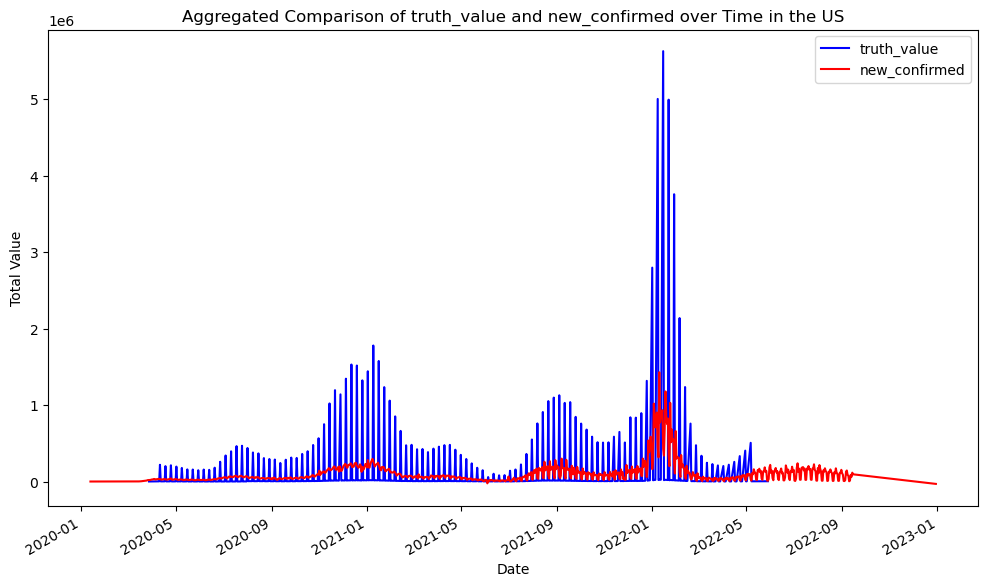

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

df_main = pd.read_csv('processed_data/unique_truth_main_dataset.csv', parse_dates=['target_end_date'])
df_google = pd.read_csv('processed_data/unique_truth_google_dataset.csv', parse_dates=['date'])
df_main_summed = df_main.groupby('target_end_date')['truth_value'].sum().reset_index()
df_google_summed = df_google.groupby('date')['new_confirmed'].sum().reset_index()

df_google_summed.to_csv('processed_data/test_google.csv', index=False)
df_main_summed.to_csv('processed_data/test_main.csv', index=False)

plt.figure(figsize=(12, 7))
plt.plot(df_main_summed['target_end_date'], df_main_summed['truth_value'], label='truth_value', color='blue')
plt.plot(df_google_summed['date'], df_google_summed['new_confirmed'], label='new_confirmed', color='red')
plt.xlabel('Date')
plt.ylabel('Total Value')
plt.title('Aggregated Comparison of truth_value and new_confirmed over Time in the US')
plt.legend()
plt.gcf().autofmt_xdate()

# Show the plot
plt.show()



In [2]:
import pandas as pd

df = pd.read_csv('raw_datasets/main_dataset/forecasts_and_truth.csv')

unique_combinations = df[['target_end_date', 'abbreviation']].drop_duplicates()

inconsistencies_counter = 0

# Calculate the total number of iterations for progress tracking
total_combinations = len(unique_combinations)
print("Starting consistency check...")

for index, row in enumerate(unique_combinations.itertuples(index=False), 1):
    target_date = row.target_end_date
    abbreviation = row.abbreviation
    
    filtered_df = df[(df['target_end_date'] == target_date) & (df['abbreviation'] == abbreviation)]
    
    if len(filtered_df) > 1:
        if filtered_df['truth_value'].nunique() > 1:
            inconsistencies_counter += 1
    
    # Print progress percentage
    progress_percentage = (index / total_combinations) * 100
    print(f"Progress: {progress_percentage:.2f}%", end='\r')

print("\nConsistency check completed.")
print(f"Number of duplicated sets with different 'truth_value': {inconsistencies_counter}")

Starting consistency check...
Progress: 100.00%
Consistency check completed.
Number of duplicated sets with different 'truth_value': 7069


Using cases data from Google Repo

In [7]:
import os
import pandas as pd
import statsmodels.api as sm

# Adjust these paths to where your datasets are located
truth_data_path = 'processed_data/unique_truth_google_dataset.csv'
datasets_folder_path = 'raw_datasets/supplementary_dataset_TS'

# Load the truth data
truth_data = pd.read_csv(truth_data_path)

# Ensure 'new_confirmed' is in truth_data
if 'new_confirmed' not in truth_data.columns:
    raise ValueError("Column 'new_confirmed' not found in truth data.")

results = []

# Iterate over each dataset in the folder
for filename in os.listdir(datasets_folder_path):
    if filename.endswith('.csv'):
        dataset_path = os.path.join(datasets_folder_path, filename)
        data = pd.read_csv(dataset_path)

        # Debug: Print columns to verify structure
        print(f"Processing {filename}, columns: {data.columns.tolist()}")

        # Merge with truth_data on date and location
        merged_data = pd.merge(truth_data, data, on=['date', 'location_key'])

        # Ensure 'new_confirmed' is in merged_data
        if 'new_confirmed' not in merged_data.columns:
            print(f"Warning: 'new_confirmed' not found after merging with {filename}. Skipping this file.")
            continue  # Skip this file if 'new_confirmed' is not in the merged data

        for column in data.columns:
            if column not in ['date', 'location_key']:
                try:
                    # Drop rows where the current column or truth_value has NaN
                    clean_merged_data = merged_data.dropna(subset=[column, 'new_confirmed'])

                    if not clean_merged_data.empty:
                        if pd.api.types.is_numeric_dtype(clean_merged_data[column]):
                            X = sm.add_constant(clean_merged_data[column])  # Add constant
                            y = clean_merged_data['new_confirmed']

                            model = sm.OLS(y, X).fit()

                            results.append({
                                'filename': filename,
                                'variable': column,
                                'correlation': model.rsquared
                            })
                except KeyError as e:
                    print(f"KeyError encountered for column {e} in file {filename}. It might be missing after the merge.")

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='correlation', ascending=False)
results_df.to_csv('processed_data/Google_OLS_correlation_ranking.csv', index=False)
print(results_df.head())

C:\Users\kalei\AppData\Local\Temp\ipykernel_68256\3989863956.py:22: DtypeWarning: Columns (148,149,150,151) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_path)


Processing by-age.csv, columns: ['date', 'location_key', 'new_confirmed_age_0', 'new_confirmed_age_1', 'new_confirmed_age_2', 'new_confirmed_age_3', 'new_confirmed_age_4', 'new_confirmed_age_5', 'new_confirmed_age_6', 'new_confirmed_age_7', 'new_confirmed_age_8', 'new_confirmed_age_9', 'cumulative_confirmed_age_0', 'cumulative_confirmed_age_1', 'cumulative_confirmed_age_2', 'cumulative_confirmed_age_3', 'cumulative_confirmed_age_4', 'cumulative_confirmed_age_5', 'cumulative_confirmed_age_6', 'cumulative_confirmed_age_7', 'cumulative_confirmed_age_8', 'cumulative_confirmed_age_9', 'new_deceased_age_0', 'new_deceased_age_1', 'new_deceased_age_2', 'new_deceased_age_3', 'new_deceased_age_4', 'new_deceased_age_5', 'new_deceased_age_6', 'new_deceased_age_7', 'new_deceased_age_8', 'new_deceased_age_9', 'cumulative_deceased_age_0', 'cumulative_deceased_age_1', 'cumulative_deceased_age_2', 'cumulative_deceased_age_3', 'cumulative_deceased_age_4', 'cumulative_deceased_age_5', 'cumulative_decease

C:\Users\kalei\AppData\Local\Temp\ipykernel_68256\3989863956.py:22: DtypeWarning: Columns (5,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_path)


Processing Global_vaccination_search_insights.csv, columns: ['date', 'country_region', 'country_region_code', 'sub_region_1', 'location_key', 'sub_region_2', 'sub_region_2_code', 'sub_region_3', 'sub_region_3_code', 'place_id', 'sni_covid19_vaccination', 'sni_vaccination_intent', 'sni_safety_side_effects']
Processing google-search-trends.csv, columns: ['date', 'location_key', 'search_trends_abdominal_obesity', 'search_trends_abdominal_pain', 'search_trends_acne', 'search_trends_actinic_keratosis', 'search_trends_acute_bronchitis', 'search_trends_adrenal_crisis', 'search_trends_ageusia', 'search_trends_alcoholism', 'search_trends_allergic_conjunctivitis', 'search_trends_allergy', 'search_trends_amblyopia', 'search_trends_amenorrhea', 'search_trends_amnesia', 'search_trends_anal_fissure', 'search_trends_anaphylaxis', 'search_trends_anemia', 'search_trends_angina_pectoris', 'search_trends_angioedema', 'search_trends_angular_cheilitis', 'search_trends_anosmia', 'search_trends_anxiety', 'se

In [8]:
# ranked data merging google dataset

import os
import pandas as pd

# Load the truth data
truth_data_path = 'processed_data/unique_truth_google_dataset.csv'
datasets_folder_path = 'raw_datasets/supplementary_dataset_TS'
truth_data = pd.read_csv(truth_data_path)

# Load the correlation data
correlation_data_path = 'processed_data/Google_OLS_correlation_ranking.csv'
correlation_data = pd.read_csv(correlation_data_path)

# Filter variables with R^2 greater than 0.04
selected_variables = correlation_data[correlation_data['correlation'] > 0.2]

# Iterate over each dataset in the folder
for filename in os.listdir(datasets_folder_path):
    if filename.endswith('.csv'):
        dataset_path = os.path.join(datasets_folder_path, filename)
        data = pd.read_csv(dataset_path)
        
        print(f"Processing {dataset_path}...")
        
        # Process only selected variables for the current dataset
        for _, row in selected_variables.iterrows():
            if row['filename'] == filename:
                column = row['variable']
                
                # Verify if the column exists in the current dataset
                if column in data.columns:
                    # Create a temporary DataFrame to hold the current column's data
                    temp_data = data[['date', 'location_key', column]].dropna()

                    # Merge the temporary DataFrame with the truth_data DataFrame
                    truth_data = pd.merge(truth_data, temp_data, on=['date', 'location_key'], how='left', suffixes=('', '_temp'))

                    # Check if the merged column exists (avoid overwriting existing data)
                    if f'{column}_temp' in truth_data.columns:
                        # If the column already exists in truth_data, we combine the original and new columns
                        truth_data[column] = truth_data[column].combine_first(truth_data[f'{column}_temp'])
                        # Drop the temporary column after combining
                        truth_data.drop(columns=[f'{column}_temp'], inplace=True)

# After processing all files, save the updated truth_data DataFrame
truth_data.to_csv('processed_data/Google_ranked_merged_dataset.csv', index=False)

truth_data.head()

C:\Users\kalei\AppData\Local\Temp\ipykernel_68256\3172506733.py:22: DtypeWarning: Columns (148,149,150,151) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_path)


Processing raw_datasets/supplementary_dataset_TS\by-age.csv...
Processing raw_datasets/supplementary_dataset_TS\by-sex.csv...
Processing raw_datasets/supplementary_dataset_TS\epidemiology.csv...


C:\Users\kalei\AppData\Local\Temp\ipykernel_68256\3172506733.py:22: DtypeWarning: Columns (5,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_path)


Processing raw_datasets/supplementary_dataset_TS\Global_vaccination_search_insights.csv...
Processing raw_datasets/supplementary_dataset_TS\google-search-trends.csv...
Processing raw_datasets/supplementary_dataset_TS\hospitalizations.csv...
Processing raw_datasets/supplementary_dataset_TS\lawatlas-emergency-declarations.csv...
Processing raw_datasets/supplementary_dataset_TS\mobility.csv...
Processing raw_datasets/supplementary_dataset_TS\oxford-government-response.csv...
Processing raw_datasets/supplementary_dataset_TS\vaccinations.csv...
Processing raw_datasets/supplementary_dataset_TS\weather.csv...


,date,location_key,new_confirmed,new_confirmed_age_6,new_confirmed_age_7,new_tested_age_0,new_confirmed_age_8,new_tested_age_1,new_tested_age_2,new_tested_age_3,...,new_confirmed_male,new_confirmed_female,new_hospitalized_patients,current_ventilator_patients,current_hospitalized_patients,cumulative_intensive_care_patients,new_intensive_care_patients,current_intensive_care_patients,lawatlas_home_except_obtaining_necessary_supplies,lawatlas_home_except_engaging_in_outdoor_activities
0,2020-01-13,US_WA,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-14,US_WA,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-15,US_WA,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-16,US_WA,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-17,US_WA,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd
import numpy as np

results_df = pd.read_csv('processed_data/Google_ranked_merged_dataset.csv')

missing_value_percentages = results_df.select_dtypes(include=[np.number]).isnull().mean().sort_values() * 100

print(missing_value_percentages)

new_confirmed                                           0.000000
new_hospitalized_patients                               6.508908
current_hospitalized_patients                          12.399941
current_intensive_care_patients                        16.455790
current_ventilator_patients                            83.167952
new_intensive_care_patients                            92.434247
cumulative_intensive_care_patients                     93.011546
new_confirmed_age_2                                    94.332141
new_confirmed_age_0                                    94.332141
new_confirmed_age_3                                    94.332141
new_confirmed_age_1                                    94.332141
new_deceased_age_9                                     94.525803
lawatlas_home_except_obtaining_necessary_supplies      96.021616
lawatlas_home_except_engaging_in_outdoor_activities    96.021616
new_confirmed_age_6                                    96.775978
new_confirmed_age_7      

In [ ]:
# Google dataset

import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split

# Load the dataset
final_dataset = pd.read_csv('processed_data/Google_ranked_merged_dataset.csv')

# Load correlation data to filter variables
selected_variables = [
    'new_hospitalized_patients',
    'current_hospitalized_patients',
    'current_intensive_care_patients',
    'location_key_US_AK', 'location_key_US_AL', 'location_key_US_AR', 'location_key_US_AZ', 'location_key_US_CA', 'location_key_US_CO', 'location_key_US_CT', 'location_key_US_DE', 'location_key_US_FL', 'location_key_US_GA', 'location_key_US_HI', 'location_key_US_IA', 'location_key_US_ID', 'location_key_US_IL', 'location_key_US_IN', 'location_key_US_KS', 'location_key_US_KY', 'location_key_US_LA', 'location_key_US_MA', 'location_key_US_MD', 'location_key_US_ME', 'location_key_US_MI', 'location_key_US_MN', 'location_key_US_MO', 'location_key_US_MS', 'location_key_US_MT', 'location_key_US_NC', 'location_key_US_ND', 'location_key_US_NE', 'location_key_US_NH', 'location_key_US_NJ', 'location_key_US_NM', 'location_key_US_NV', 'location_key_US_NY', 'location_key_US_OH', 'location_key_US_OK', 'location_key_US_OR', 'location_key_US_PA', 'location_key_US_PR', 'location_key_US_RI', 'location_key_US_SC', 'location_key_US_SD', 'location_key_US_TN', 'location_key_US_TX', 'location_key_US_UT', 'location_key_US_VA', 'location_key_US_VT', 'location_key_US_WA', 'location_key_US_WI', 'location_key_US_WV', 'location_key_US_WY'
]

pre_selected_variables = [
    'new_hospitalized_patients',
    'current_hospitalized_patients',
    'current_intensive_care_patients'
]

for column in pre_selected_variables:
    if final_dataset[column].dtype != 'object':  # If column is numerical
        final_dataset[column].fillna(final_dataset[column].mean(), inplace=True)

# Assuming 'location_key' needs to be converted into dummies and included in the regression
final_dataset = pd.get_dummies(final_dataset, columns=['location_key'], dtype=int)

# Now define X and y
selected_variables = pre_selected_variables + [col for col in final_dataset.columns if 'location_key_' in col]

X = final_dataset[selected_variables]  # Ensure this includes all your independent variables
y = final_dataset['new_confirmed'].apply(pd.to_numeric, errors='coerce')  # Adjust column name as needed

# Add constant to X
X = sm.add_constant(X)

# Handle any potential NaN values in X or y before regression
X.fillna(X.mean(), inplace=True)
y.fillna(y.mean(), inplace=True)

# Perform the regression
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

np.linalg.cond(X.values) # if greater than 30, multicollinearity is a problem

                            OLS Regression Results                            
Dep. Variable:          new_confirmed   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     847.2
Date:                Tue, 05 Mar 2024   Prob (F-statistic):               0.00
Time:                        12:22:47   Log-Likelihood:            -5.2593e+05
No. Observations:               54218   AIC:                         1.052e+06
Df Residuals:                   54159   BIC:                         1.053e+06
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to calculate VIF for each feature
def calculate_vifs(X):
    vif_data = pd.DataFrame()
    vif_data["variable"] = X.columns
    
    # Calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif_data

# Exclude the constant for VIF calculation
X_vif = X.drop(['const'], axis=1)

vif_data = calculate_vifs(X_vif)

# Filter out variables with VIF greater than a threshold (commonly 5 or 10)
print(vif_data[vif_data["VIF"] > 5].sort_values(by="VIF", ascending=False))

Null persentage checking

In [3]:
import pandas as pd
import os

datasets_folder_path = 'raw_datasets/supplementary_dataset_TS'

# Columns to exclude from the missing value analysis
excluded_columns = [
    'date', 'location_key', 'country_region', 'country_region_code',
    'place_id', 'sub_region_1', 'sub_region_2'
]

# Initialize a list to store missing value data
missing_value_data = []

# Iterate over each file in the folder
for file in os.listdir(datasets_folder_path):
    if file.endswith('.csv'):
        file_path = os.path.join(datasets_folder_path, file)
        df = pd.read_csv(file_path)
        
        # Calculate missing value percentage for each column and store the results
        for column in df.columns:
            if column not in excluded_columns:  # Check if the column is not excluded
                missing_percentage = df[column].isnull().mean() * 100
                missing_value_data.append({'File': file, 'Column': column, 'MissingPercentage': missing_percentage})

# Create a DataFrame from the collected data
missing_value_df = pd.DataFrame(missing_value_data)

# Sort the DataFrame by missing percentage, from low to high
missing_value_df_sorted = missing_value_df.sort_values(by='MissingPercentage', ascending=True)

# Output the sorted DataFrame to a new CSV file
output_file_path = 'processed_data/missing_value_percentage_summary.csv'
missing_value_df_sorted.to_csv(output_file_path, index=False)


C:\Users\kalei\AppData\Local\Temp\ipykernel_78824\1499504076.py:19: DtypeWarning: Columns (148,149,150,151) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\kalei\AppData\Local\Temp\ipykernel_78824\1499504076.py:19: DtypeWarning: Columns (5,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Week 4 new attempt

In [ ]:
import pandas as pd

df = pd.read_csv('raw_datasets/main_dataset/forecasts_and_truth.csv')
filtered_df = df[df['target_variable'] == 'inc case']
filtered_df = filtered_df[filtered_df['abbreviation'] != 'US']
filtered_df = filtered_df.drop_duplicates(subset=['target_end_date', 'abbreviation'], keep='first')
result_df = filtered_df[['target_end_date', 'abbreviation', 'truth_value']]
result_df.to_csv('processed_data/week4_filtered_dataset.csv', index=False)

In [3]:
import os
import pandas as pd
import statsmodels.api as sm

# Adjust these paths to where your datasets are located
truth_data_path = 'processed_data/week4_filtered_dataset.csv'
datasets_folder_path = 'raw_datasets/supplementary_dataset_TS'

# Load the truth data
truth_data = pd.read_csv(truth_data_path)
truth_data.rename(columns={'abbreviation': 'location_key', 'target_end_date': 'date'}, inplace=True)
truth_data['location_key'] = 'US_' + truth_data['location_key']

# Store results
results = []

# Iterate over each dataset in the folder
for filename in os.listdir(datasets_folder_path):
    if filename.endswith('.csv'):
        dataset_path = os.path.join(datasets_folder_path, filename)
        data = pd.read_csv(dataset_path)
        
        print(f"Processing {dataset_path}...")
        
        # Merge with truth_data on date and location
        merged_data = pd.merge(truth_data, data, on=['date', 'location_key'], how='inner')
        
        for column in data.columns:
            if column not in ['date', 'location_key']:
                # Calculate missing value percentage for the column
                missing_percentage = merged_data[column].isnull().mean() * 100
                
                # Check if missing data percentage is greater than 20%
                if missing_percentage > 20:
                    print(f"Skipping {column} due to high missing value percentage ({missing_percentage:.2f}%)")
                    continue  # Skip to the next column
                
                # Drop rows where the current column or truth_value has NaN
                clean_merged_data = merged_data.dropna(subset=[column, 'truth_value'])

                # Check if there's still data left after dropping NaNs
                if not clean_merged_data.empty:
                    # Check if the data is numeric
                    if pd.api.types.is_numeric_dtype(clean_merged_data[column]):
                        # Prepare data for regression
                        X = sm.add_constant(clean_merged_data[column])  # Add constant
                        y = clean_merged_data['truth_value']

                        # Run linear regression
                        model = sm.OLS(y, X).fit()

                        # Record the result
                        results.append({
                            'filename': filename,
                            'variable': column,
                            'correlation': model.rsquared
                        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort results by correlation in descending order
results_df = results_df.sort_values(by='correlation', ascending=False)

results_df.to_csv('processed_data/week4_correlation_ranking.csv', index=False)

# Output the sorted results
print(results_df.head())


C:\Users\kalei\AppData\Local\Temp\ipykernel_80752\3425614309.py:21: DtypeWarning: Columns (148,149,150,151) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_path)


Processing raw_datasets/supplementary_dataset_TS\by-age.csv...
Skipping new_confirmed_age_0 due to high missing value percentage (81.71%)
Skipping new_confirmed_age_1 due to high missing value percentage (81.71%)
Skipping new_confirmed_age_2 due to high missing value percentage (81.71%)
Skipping new_confirmed_age_3 due to high missing value percentage (81.71%)
Skipping new_confirmed_age_4 due to high missing value percentage (82.05%)
Skipping new_confirmed_age_5 due to high missing value percentage (82.05%)
Skipping new_confirmed_age_6 due to high missing value percentage (90.33%)
Skipping new_confirmed_age_7 due to high missing value percentage (90.33%)
Skipping new_confirmed_age_8 due to high missing value percentage (90.81%)
Skipping new_confirmed_age_9 due to high missing value percentage (90.81%)
Skipping cumulative_confirmed_age_0 due to high missing value percentage (81.71%)
Skipping cumulative_confirmed_age_1 due to high missing value percentage (81.71%)
Skipping cumulative_con

In [8]:
import os
import pandas as pd

# Load the truth data
truth_data_path = 'processed_data/week4_filtered_dataset.csv'
datasets_folder_path = 'raw_datasets/supplementary_dataset_TS'
truth_data = pd.read_csv(truth_data_path)
truth_data.rename(columns={'abbreviation': 'location_key', 'target_end_date': 'date'}, inplace=True)
truth_data['location_key'] = 'US_' + truth_data['location_key']

# Load the correlation data
correlation_data_path = 'processed_data/week4_correlation_ranking.csv'
correlation_data = pd.read_csv(correlation_data_path)

# Filter variables with R^2 greater than 0.04
selected_variables = correlation_data[correlation_data['correlation'] > 0.1]

# Iterate over each dataset in the folder
for filename in os.listdir(datasets_folder_path):
    if filename.endswith('.csv'):
        dataset_path = os.path.join(datasets_folder_path, filename)
        data = pd.read_csv(dataset_path)
        
        print(f"Processing {dataset_path}...")
        
        # Process only selected variables for the current dataset
        for _, row in selected_variables.iterrows():
            if row['filename'] == filename:
                column = row['variable']
                
                # Verify if the column exists in the current dataset
                if column in data.columns:
                    # Create a temporary DataFrame to hold the current column's data
                    temp_data = data[['date', 'location_key', column]].dropna()

                    # Merge the temporary DataFrame with the truth_data DataFrame
                    truth_data = pd.merge(truth_data, temp_data, on=['date', 'location_key'], how='left', suffixes=('', '_temp'))

                    # Check if the merged column exists (avoid overwriting existing data)
                    if f'{column}_temp' in truth_data.columns:
                        # If the column already exists in truth_data, we combine the original and new columns
                        truth_data[column] = truth_data[column].combine_first(truth_data[f'{column}_temp'])
                        # Drop the temporary column after combining
                        truth_data.drop(columns=[f'{column}_temp'], inplace=True)

# After processing all files, save the updated truth_data DataFrame
truth_data.to_csv('processed_data/week4_ranked_merged_dataset_main.csv', index=False)

truth_data.head()

C:\Users\kalei\AppData\Local\Temp\ipykernel_80752\2620864809.py:22: DtypeWarning: Columns (148,149,150,151) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_path)


Processing raw_datasets/supplementary_dataset_TS\by-age.csv...
Processing raw_datasets/supplementary_dataset_TS\by-sex.csv...
Processing raw_datasets/supplementary_dataset_TS\epidemiology.csv...
Processing raw_datasets/supplementary_dataset_TS\google-search-trends.csv...
Processing raw_datasets/supplementary_dataset_TS\hospitalizations.csv...
Processing raw_datasets/supplementary_dataset_TS\lawatlas-emergency-declarations.csv...
Processing raw_datasets/supplementary_dataset_TS\mobility.csv...
Processing raw_datasets/supplementary_dataset_TS\oxford-government-response.csv...
Processing raw_datasets/supplementary_dataset_TS\vaccinations.csv...
Processing raw_datasets/supplementary_dataset_TS\weather.csv...


,date,location_key,truth_value,cumulative_deceased_age_0,cumulative_deceased_age_5,cumulative_deceased_age_4,cumulative_confirmed_male,cumulative_confirmed_female,new_confirmed,cumulative_confirmed,...,cumulative_hospitalized_patients,cumulative_vaccine_doses_administered_pfizer,cumulative_vaccine_doses_administered_moderna,cumulative_vaccine_doses_administered_janssen,cumulative_persons_fully_vaccinated_pfizer,cumulative_vaccine_doses_administered,cumulative_persons_fully_vaccinated_janssen,cumulative_persons_vaccinated,cumulative_persons_fully_vaccinated_moderna,cumulative_persons_fully_vaccinated
0,2020-04-11,US_AL,1630,NaN,NaN,NaN,NaN,NaN,223.0,3191.0,...,402.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-04-11,US_AK,86,NaN,NaN,NaN,NaN,NaN,15.0,272.0,...,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-04-11,US_AZ,1374,NaN,NaN,NaN,NaN,NaN,281.0,3393.0,...,1037.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-04-11,US_AR,485,NaN,NaN,NaN,NaN,NaN,55.0,1226.0,...,130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-04-11,US_CA,8625,NaN,NaN,NaN,NaN,NaN,1143.0,20615.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
import pandas as pd
import os

main_data_path = 'processed_data/week4_ranked_merged_dataset_main.csv'
main_data = pd.read_csv(main_data_path)

# Example: new_data_info = [('path_to_new_data.csv', ['new_column1', 'new_column2']), ...]
new_data_info = [
    ('raw_datasets/supplementary_dataset_TS/weather.csv', ['average_temperature_celsius', 'dew_point']),
    ('raw_datasets/supplementary_dataset_TS/mobility.csv', ['mobility_workplaces']),
    ('raw_datasets/supplementary_dataset_TS/google-search-trends.csv', ['search_trends_pain', 'search_trends_infection']),
    ('raw_datasets/supplementary_dataset_TS/by-sex.csv', ['cumulative_confirmed_male', 'cumulative_confirmed_female']),
    ('raw_datasets/supplementary_dataset_TS/oxford-government-response.csv', ['stringency_index', 'vaccination_policy'])
]

for data_path, columns_to_add in new_data_info:
    if os.path.exists(data_path):
        new_data = pd.read_csv(data_path)
        
        if 'date' in new_data.columns and 'location_key' in new_data.columns:
            for column in columns_to_add:
                if column in new_data.columns:
                    temp_data = new_data[['date', 'location_key', column]].dropna()
                    
                    main_data = pd.merge(main_data, temp_data, on=['date', 'location_key'], how='left', suffixes=('', '_new'))
                    
                    if f'{column}_new' in main_data.columns:
                        main_data[column].update(main_data.pop(f'{column}_new'))
                else:
                    print(f"Column '{column}' not found in {data_path}.")
        else:
            print(f"'date' or 'location_key' column missing in {data_path}.")
    else:
        print(f"File not found: {data_path}.")

main_data.to_csv('processed_data/week4_ranked_merged_dataset_main.csv', index=False)

In [127]:
import pandas as pd
import numpy as np

results_df = pd.read_csv('processed_data\week4_ranked_merged_dataset_main.csv')

missing_value_percentages = results_df.select_dtypes(include=[np.number]).isnull().mean().sort_values() * 100

print(missing_value_percentages)

truth_value                                       0.000000
dew_point                                         0.000000
average_temperature_celsius                       0.000000
new_deceased                                      0.000000
cumulative_deceased                               0.000000
new_confirmed                                     0.000000
cumulative_confirmed                              0.000000
new_hospitalized_patients                         2.023889
current_hospitalized_patients                     4.562044
cumulative_hospitalized_patients                  7.216324
vaccination_policy                                7.780358
mobility_workplaces                               7.780358
search_trends_pain                                7.780358
search_trends_common_cold                         7.780358
search_trends_infection                           7.780358
search_trends_cough                               7.780358
stringency_index                                  7.7969

In [173]:
# Main dataset regression

import pandas as pd
import statsmodels.api as sm

# Load the dataset
final_dataset = pd.read_csv('processed_data/week4_ranked_merged_dataset_main.csv')

# Load correlation data to filter variables
selected_variables = [
    'new_hospitalized_patients',
    #'current_intensive_care_patients',
    'new_deceased',
    # 'search_trends_common_cold',
    'cumulative_persons_vaccinated',
    'average_temperature_celsius',
    # 'search_trends_infection',
    'cumulative_confirmed_male',
    #'cumulative_confirmed_female',
    # 'stringency_index',
    # 'vaccination_policy',
    # 'current_hospitalized_patients',
    'location_key_US_AK', 'location_key_US_AL', 'location_key_US_AR', 'location_key_US_AZ', 'location_key_US_CA', 'location_key_US_CO', 'location_key_US_CT', 'location_key_US_DE', 'location_key_US_FL', 'location_key_US_GA', 'location_key_US_HI', 'location_key_US_IA', 'location_key_US_ID', 'location_key_US_IL', 'location_key_US_IN', 'location_key_US_KS', 'location_key_US_KY', 'location_key_US_LA', 'location_key_US_MA', 'location_key_US_MD', 'location_key_US_ME', 'location_key_US_MI', 'location_key_US_MN', 'location_key_US_MO', 'location_key_US_MS', 'location_key_US_MT', 'location_key_US_NC', 'location_key_US_ND', 'location_key_US_NE', 'location_key_US_NH', 'location_key_US_NJ', 'location_key_US_NM', 'location_key_US_NV', 'location_key_US_NY', 'location_key_US_OH', 'location_key_US_OK', 'location_key_US_OR', 'location_key_US_PA', 'location_key_US_PR', 'location_key_US_RI', 'location_key_US_SC', 'location_key_US_SD', 'location_key_US_TN', 'location_key_US_TX', 'location_key_US_UT', 'location_key_US_VA', 'location_key_US_VT', 'location_key_US_WA', 'location_key_US_WI', 'location_key_US_WV', 'location_key_US_WY'
]

pre_selected_variables = [
    'new_hospitalized_patients',
    #'current_intensive_care_patients',
    'new_deceased',
    # 'search_trends_common_cold',
    'cumulative_persons_vaccinated',
    'average_temperature_celsius',
    # 'search_trends_infection',
    'cumulative_confirmed_male',
    #'cumulative_confirmed_female',
    # 'stringency_index',
    # 'vaccination_policy',
    # 'current_hospitalized_patients'
]

# Impute missing values for numerical columns
for column in pre_selected_variables:
    if final_dataset[column].dtype != 'object':
        final_dataset[column].fillna(final_dataset[column].mean(), inplace=True)
        
X = X.apply(pd.to_numeric, errors='coerce')

X.fillna(X.mean(), inplace=True)

y = pd.to_numeric(y, errors='coerce').fillna(y.mean())

# Create dummy variables for 'location_key'
final_dataset = pd.get_dummies(final_dataset, columns=['location_key'], dtype=int)

X = final_dataset[[col for col in final_dataset.columns if col in selected_variables or 'location_key_' in col]]
y = final_dataset['truth_value']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            truth_value   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     231.7
Date:                Tue, 12 Mar 2024   Prob (F-statistic):               0.00
Time:                        05:02:47   Log-Likelihood:                -67843.
No. Observations:                6028   AIC:                         1.358e+05
Df Residuals:                    5967   BIC:                         1.362e+05
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [164]:
import numpy as np

predictions = model.predict(X)

# Errors
errors = y - predictions

# Mean Absolute Error (MAE)
mae = np.mean(np.abs(errors))

# Mean Squared Error (MSE)
mse = np.mean(errors**2)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 7058.942761408815
RMSE: 18689.267087261116


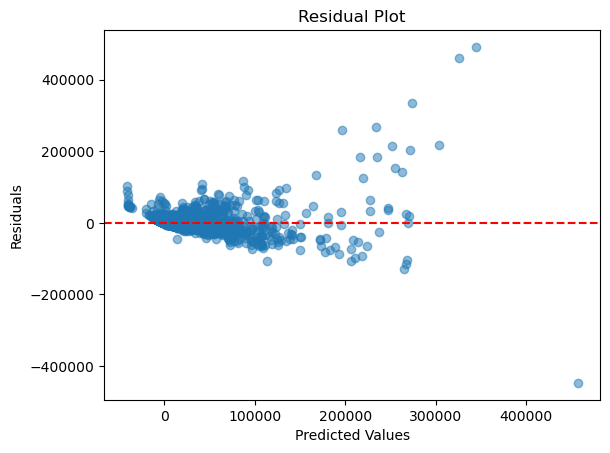

In [165]:
# Residual Plot
plt.scatter(predictions, errors, alpha=0.5)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

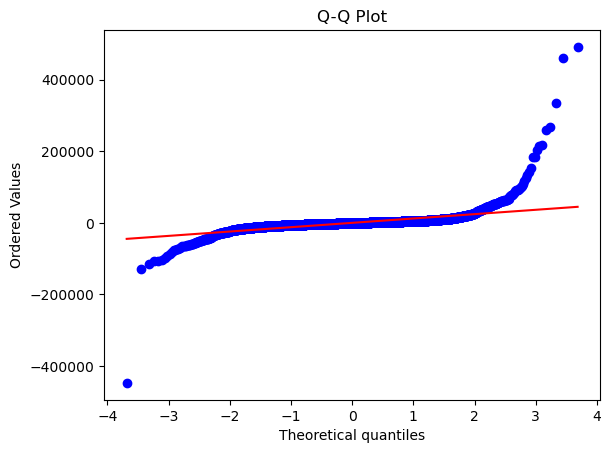

In [166]:
import scipy.stats as stats

# Q-Q plot
stats.probplot(errors, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()


In [167]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X_vif = X.loc[:, ~X.columns.str.startswith('location_key')]
X_vif = X_vif.drop(columns=['const'], errors='ignore')

# calculate VIF for each feature
def calculate_vifs(X):
    vif_data = pd.DataFrame()
    vif_data["variable"] = X.columns

    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif_data

vif_data = calculate_vifs(X_vif)

# Filter out variables with VIF greater than a threshold (commonly 5 or 10)
print(vif_data[vif_data["VIF"] > 0].sort_values(by="VIF", ascending=False))


                        variable       VIF
0      cumulative_confirmed_male  3.005317
3  cumulative_persons_vaccinated  2.354372
4    average_temperature_celsius  2.054973
2      new_hospitalized_patients  2.043770
1                   new_deceased  1.555676


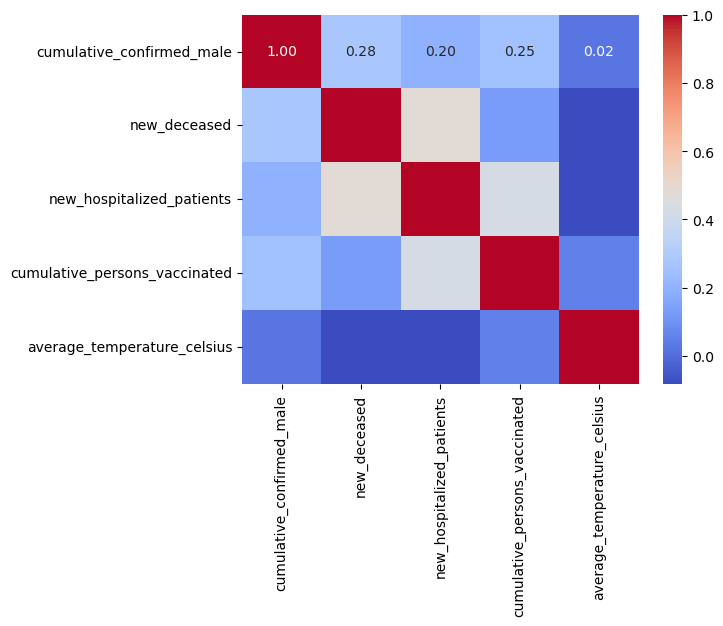

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt

filtered_X = X.loc[:, ~X.columns.str.startswith('location_key')]
filtered_X = filtered_X.loc[:, filtered_X.std() > 0]
corr = filtered_X.corr()

# heatmap
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()


In [170]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

selected_variables = [
    'new_hospitalized_patients',
    'new_deceased',
    'cumulative_persons_vaccinated',
    'average_temperature_celsius',
    'cumulative_confirmed_male',
    # 'current_hospitalized_patients'
]

# Define X and y from the final_dataset
X = final_dataset[selected_variables]
y = final_dataset['truth_value'].astype(float)  # Ensure y is of numeric type

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = rf_model.predict(X_test)

# Calculate RMSE and R^2 for the test set
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f"Test RMSE: {rmse}")
print(f"Test R^2 Score: {r2}")

# Feature Importances
feature_importances = rf_model.feature_importances_
importances_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})
importances_df.sort_values(by='importance', ascending=False, inplace=True)

print(importances_df)


Test RMSE: 10522.837785627235
Test R^2 Score: 0.9033179930517123
                         feature  importance
0      new_hospitalized_patients    0.728239
2  cumulative_persons_vaccinated    0.143779
3    average_temperature_celsius    0.091907
1                   new_deceased    0.028515
4      cumulative_confirmed_male    0.007560


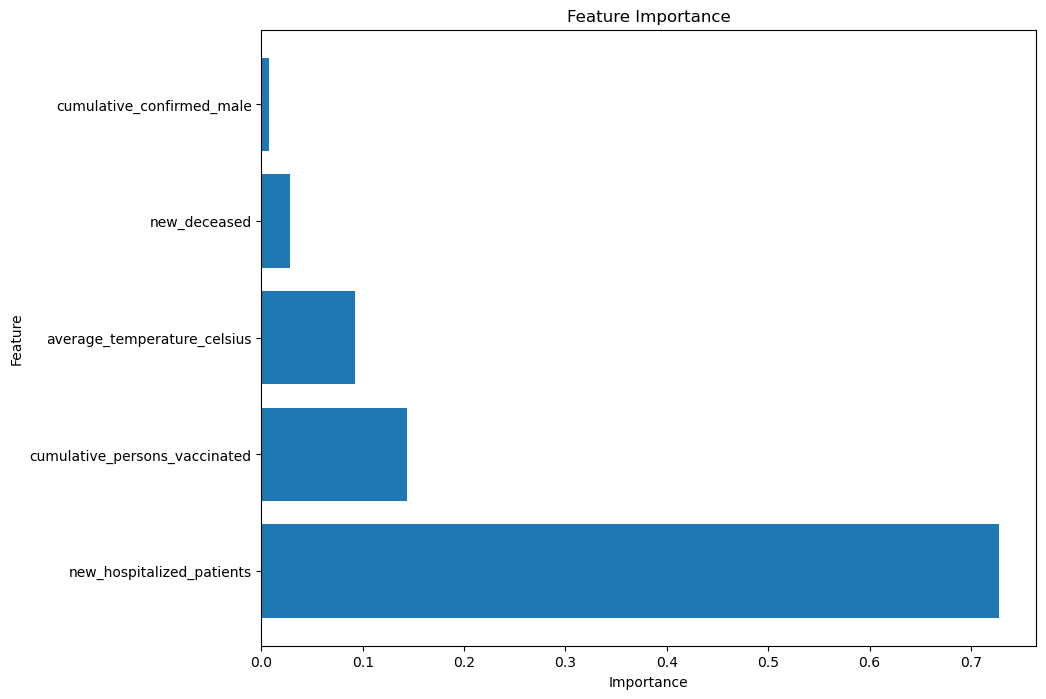

In [171]:
import matplotlib.pyplot as plt

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importances_df['feature'], importances_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()